<a href="https://colab.research.google.com/github/DaneshSelwal/CODSOFT/blob/main/Flood_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Start Section:**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install bayesian-optimization
!pip install optuna
!pip install catboost
!pip install gpboost
!pip install shap
!pip install ngboost

# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f088a30832a12235f88a4e4910f26e0b9ddf01309d64737e423d3256a33eeb2d
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,make_scorer
from scipy.stats import pearsonr, uniform, randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from gpboost import GPBoostRegressor
from ngboost import NGBRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [6]:
train_data_path = '/content/drive/MyDrive/flood_scour_data/training_data.csv'
test_data_path = '/content/drive/MyDrive/flood_scour_data/test_data.csv'

In [7]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
print("Training data loaded successfully.")
print("Test data loaded successfully.")

Training data loaded successfully.
Test data loaded successfully.


In [8]:
print("\nShape of training data:", train_data.shape)
print("First 10 rows of training data:\n", train_data.head(5))
print("\nShape of test data:", test_data.shape)
print("First 10 rows of test data:\n", test_data.head(5))


Shape of training data: (154, 8)
First 10 rows of training data:
     Ps   Pw   Skew     Velocity     Depth     D50     Gradation     Scour  
0  0.7  1.5        0          2.9       6.6   70.00           1.2       0.6
1  0.7  1.5        0          3.0       5.3   70.00           1.2       0.6
2  1.3  3.3        0          0.8       4.8    0.48           1.8       0.4
3  1.0  4.3        0          2.9       9.7    0.30           1.4       3.7
4  0.7  0.5       20          1.4       1.8    1.10           3.5       0.3

Shape of test data: (78, 8)
First 10 rows of test data:
     Ps   Pw   Skew     Velocity     Depth     D50     Gradation     Scour  
0  1.3  0.3       16          1.0       0.3    0.94           3.0       0.4
1  1.0  0.8        0          0.2       1.5    0.25           8.0       0.2
2  1.0  0.6       10          1.6       6.6    0.90           4.2       1.1
3  1.3  1.2        0          0.8       3.1    0.38           2.3       1.6
4  1.0  0.8        0          1.1      

In [9]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
x_test= X_test
print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (154, 7)
Shape of y_train: (154,)
Shape of X_test: (78, 7)
Shape of y_test: (78,)


In [10]:
# Apply z-score normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print the first five rows of the normalized data
print("\nFirst five rows of normalized X_train:")
print(X_train[:5])

print("\nFirst five rows of normalized X_test:")
print(X_test[:5])


First five rows of normalized X_train:
[[-1.30505288 -0.05072804 -0.49867969  1.41932674  0.51129506  1.91265145
  -0.75772712]
 [-1.30505288 -0.05072804 -0.49867969  1.53187891  0.18675076  1.91265145
  -0.75772712]
 [ 1.56606345  1.51169548 -0.49867969 -0.94426887  0.06192603 -0.69389788
  -0.5721613 ]
 [ 0.13050529  2.37970854 -0.49867969  1.41932674  1.28520839 -0.70064672
  -0.69587185]
 [-1.30505288 -0.9187411   0.57841248 -0.26895584 -0.68702234 -0.6706519
  -0.04639146]]

First five rows of normalized X_test:
[[ 1.56606345 -1.09234371  0.36299405 -0.71916453 -1.06149653 -0.67665086
  -0.20102964]
 [ 0.13050529 -0.65833718 -0.49867969 -1.6195819  -0.76191718 -0.70252139
   1.34535224]
 [ 0.13050529 -0.83193979  0.0398664  -0.0438515   0.51129506 -0.6781506
   0.17010201]
 [ 1.56606345 -0.31113196 -0.49867969 -0.94426887 -0.36247805 -0.69764723
  -0.41752311]
 [ 0.13050529 -0.65833718 -0.49867969 -0.60661235 -0.71198729  1.53771627
  -0.38659547]]


In [11]:
def score(mod):
  dic={
      "Train MAE":mean_absolute_error(mod.predict(X_train),y_train),
       "Test MAE": mean_absolute_error(mod.predict(X_test),y_test),
       "TESE MSE": mean_squared_error(mod.predict(X_test),y_test),
       "Correlation":pearsonr(mod.predict(X_test),y_test)
  }
  return dic

# **Random SearchCV**

NEW

In [22]:
def hyperparameter_tuning_ran(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': (LinearRegression(), {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1, None],
            'positive': [True, False]
        }),
        'Decision Tree': (DecisionTreeRegressor(), {
            'max_depth': [None] + list(randint(1, 20).rvs(10)),
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5),
            'max_features': [ 'sqrt', 'log2', None]
        }),
        'Random Forest': (RandomForestRegressor(), {
            'n_estimators': [100, 200, 300],
            'max_depth': [None] + list(randint(1, 20).rvs(10)),
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5),
            'max_features': [ 'sqrt', 'log2', None]
        }),
        'Gradient Boosting': (GradientBoostingRegressor(), {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5),
            'max_features': [ 'sqrt', 'log2']
        }),
        'XGBoost': (XGBRegressor(), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300, 500],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.5, 1],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9]
        }),
        'LightGBM': (LGBMRegressor(verbosity= -1), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300, 500],
            'num_leaves': [15, 31, 63],
            'min_child_samples': [1, 5, 10],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9]
        }),
        'GPBoost': (GPBoostRegressor(), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': randint(3, 10),
            'n_estimators': randint(100, 1000),
            'num_leaves': randint(15, 100),
            'min_child_samples': randint(1, 20),
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'alpha': [0.1, 0.5, 1.0],
            'lambda': [0.1, 0.5, 1.0]
        }),
        'CatBoost': (CatBoostRegressor(verbose=0), {
            'learning_rate': [0.01, 0.05, 0.1],
            'iterations': [100, 200, 300, 500],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [1, 3, 5],
            'border_count': [32, 64, 128]
        }),
        'SVM': (SVR(), {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 1],
            'degree': [2, 3, 4],
            'epsilon': [0.01, 0.1, 1]
        }),
        'NGBoost': (NGBRegressor(), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'natural_gradient': [True, False],
            'minibatch_frac': [0.5, 0.7, 1.0]
        })
    }

    best_scores = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Running RandomizedSearchCV for {model_name}...")
        try:
            search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            best_scores[model_name] = {
                'best_score': -search.best_score_,
                'best_params': search.best_params_,
                'test_mse': mse
            }
            print(f"Best MSE for {model_name}: {mse} with params: {search.best_params_}")
            peint(f"")
        except Exception as e:
            print(f"Failed to run RandomizedSearchCV for {model_name}. Error: {e}")

    # Find the model with the best test score
    if best_scores:
        best_model_name = min(best_scores, key=lambda k: best_scores[k]['test_mse'])
        best_model_info = best_scores[best_model_name]
        print(f"\nBest model on test data: {best_model_name}")
        print(f"Test MSE: {best_model_info['test_mse']}")
        print(f"Best Parameters: {best_model_info['best_params']}")
    else:
        print("No valid model configurations found.")

    return best_scores

best_scores_ran = hyperparameter_tuning_ran(X_train, y_train, X_test, y_test)

Running RandomizedSearchCV for Linear Regression...
Best MSE for Linear Regression: 0.2957706123297792 with params: {'positive': True, 'n_jobs': -1, 'fit_intercept': True, 'copy_X': True}
Running RandomizedSearchCV for Decision Tree...
Best MSE for Decision Tree: 0.14495705128205127 with params: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3}
Running RandomizedSearchCV for Random Forest...
Best MSE for Random Forest: 0.24138178242916702 with params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 300}
Running RandomizedSearchCV for Gradient Boosting...
Best MSE for Gradient Boosting: 0.14207733584102009 with params: {'learning_rate': 0.01, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}
Running RandomizedSearchCV for XGBoost...
Failed to run RandomizedSearchCV for XGBoost. Error: 'super' object has no attribute '__sklearn_tags__'
Ru

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags_

Best MSE for LightGBM: 0.0956221251762551 with params: {'subsample': 0.5, 'num_leaves': 63, 'n_estimators': 100, 'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Running RandomizedSearchCV for GPBoost...
Failed to run RandomizedSearchCV for GPBoost. Error: 'super' object has no attribute '__sklearn_tags__'
Running RandomizedSearchCV for CatBoost...
Best MSE for CatBoost: 0.1709993919322003 with params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 3, 'border_count': 64}
Running RandomizedSearchCV for SVM...
Best MSE for SVM: 0.12110885539260337 with params: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C': 10}
Running RandomizedSearchCV for NGBoost...
[iter 0] loss=1.6487 val_loss=0.0000 scale=2.0000 norm=2.2531
[iter 100] loss=-0.7855 val_loss=0.0000 scale=1.0000 norm=0.3160
Best MSE for NGBoost: 0.1926137001776001 with params: {'natural_gradient': True, 'n_estimators': 200, 'minibatch_frac': 0.7, 'learning_

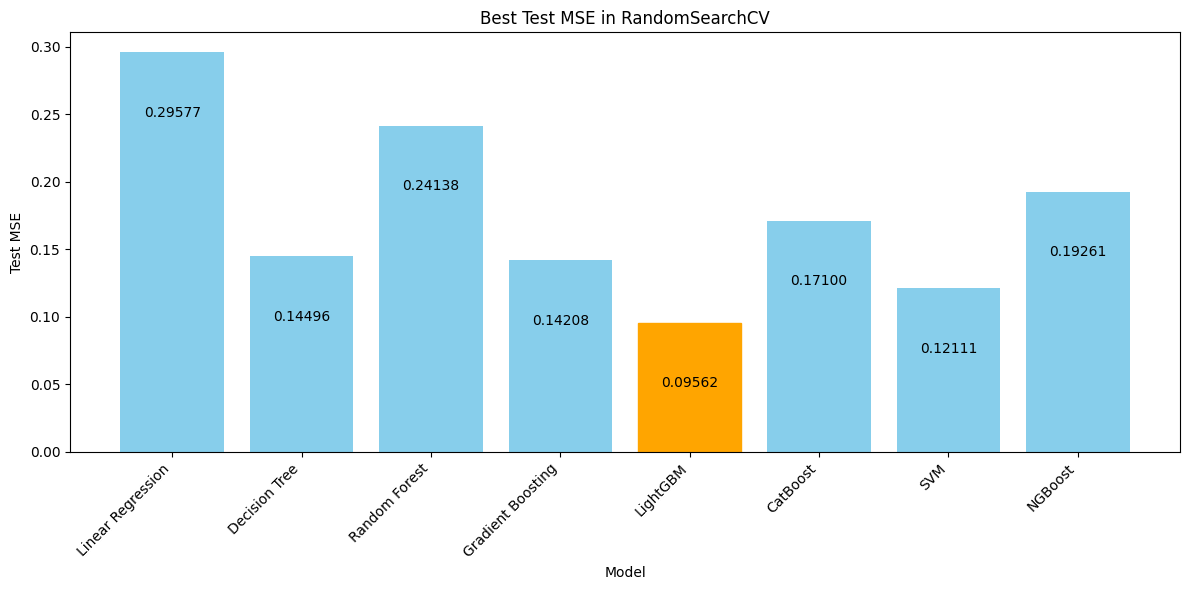

In [23]:
def plot_best_scores(best_scores_ran):
    # Extract model names and their corresponding best test MSE scores
    model_names = list(best_scores_ran.keys())
    test_mse_scores = [best_scores_ran[model]['test_mse'] for model in model_names]

    # Find the index of the model with the best (lowest) test MSE
    best_model_index = np.argmin(test_mse_scores)

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, test_mse_scores, color='skyblue')

    # Highlight the best model
    bars[best_model_index].set_color('orange')

    # Annotate the bars with the test MSE scores
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{test_mse_scores[i]:.5f}', ha='center', va='bottom', color='black')

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Test MSE')
    plt.title('Best Test MSE in RandomSearchCV')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming best_scores is the output from the hyperparameter_tuning function
plot_best_scores(best_scores_ran)

# **GridSearchCv**


In [17]:
def hyperparameter_tuning_grid(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': (LinearRegression(), {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1, None],
            'positive': [True, False]
        }),
        'Decision Tree': (DecisionTreeRegressor(), {
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }),
        'Random Forest': (RandomForestRegressor(), {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }),
        'Gradient Boosting': (GradientBoostingRegressor(), {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }),
        'XGBoost': (XGBRegressor(), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300, 500],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.5, 1],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9]
        }),
        'LightGBM': (LGBMRegressor(verbosity=-1), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300, 500],
            'num_leaves': [15, 31, 63],
            'min_child_samples': [1, 5, 10],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9]
        }),
        'GPBoost': (GPBoostRegressor(), {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300, 500],
            'num_leaves': [15, 31, 63],
            'min_child_samples': [1, 5, 10],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'alpha': [0.1, 0.5, 1.0],
            'lambda': [0.1, 0.5, 1.0]
        }),
        'CatBoost': (CatBoostRegressor(verbose=0), {
            'learning_rate': [0.01, 0.05, 0.1],
            'iterations': [100, 200, 300, 500],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [1, 3, 5],
            'border_count': [32, 64, 128]
        }),
        'SVM': (SVR(), {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 1],
            'degree': [2, 3, 4],
            'epsilon': [0.01, 0.1, 1]
        }),
        'NGBoost': (NGBRegressor(), {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'natural_gradient': [True, False],
            'minibatch_frac': [0.5, 0.7]
        })
    }

    best_scores = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Running GridSearchCV for {model_name}...")
        try:
            search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            best_scores[model_name] = {
                'best_score': -search.best_score_,
                'best_params': search.best_params_,
                'test_mse': mse
            }
            print(f"Best MSE for {model_name}: {mse} with params: {search.best_params_}")
        except Exception as e:
            print(f"Failed to run GridSearchCV for {model_name}. Error: {e}")

    # Find the model with the best test score
    if best_scores:
        best_model_name = min(best_scores, key=lambda k: best_scores[k]['test_mse'])
        best_model_info = best_scores[best_model_name]
        print(f"\nBest model on test data: {best_model_name}")
        print(f"Test MSE: {best_model_info['test_mse']}")
        print(f"Best Parameters: {best_model_info['best_params']}")
    else:
        print("No valid model configurations found.")

    return best_scores

best_scores_grid = hyperparameter_tuning_grid(X_train, y_train, X_test, y_test)


Running GridSearchCV for Linear Regression...
Best MSE for Linear Regression: 0.2957706123297792 with params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}
Running GridSearchCV for Decision Tree...
Best MSE for Decision Tree: 0.20605021367521373 with params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Running GridSearchCV for Random Forest...
Best MSE for Random Forest: 0.14943060686609894 with params: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Running GridSearchCV for Gradient Boosting...
Best MSE for Gradient Boosting: 0.13729555729894752 with params: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Running GridSearchCV for XGBoost...
Failed to run GridSearchCV for XGBoost. Error: 'super' object has no attribute '__sklearn_tags__'
Running GridSearchCV for LightGBM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags_

Best MSE for LightGBM: 0.09148999237592116 with params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 500, 'num_leaves': 15, 'subsample': 0.5}
Running GridSearchCV for GPBoost...
Failed to run GridSearchCV for GPBoost. Error: 'super' object has no attribute '__sklearn_tags__'
Running GridSearchCV for CatBoost...
Best MSE for CatBoost: 0.12885229280569716 with params: {'border_count': 64, 'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Running GridSearchCV for SVM...
Best MSE for SVM: 0.12110885539260337 with params: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Running GridSearchCV for NGBoost...
[iter 0] loss=1.6187 val_loss=0.0000 scale=2.0000 norm=2.1834
[iter 100] loss=0.6091 val_loss=0.0000 scale=2.0000 norm=1.0775
Best MSE for NGBoost: 0.16590479340310954 with params: {'learning_rate': 0.01, 'minibatch_frac': 0.5, 'n_estimators': 200, 'natural_gradient': True}

Best model on

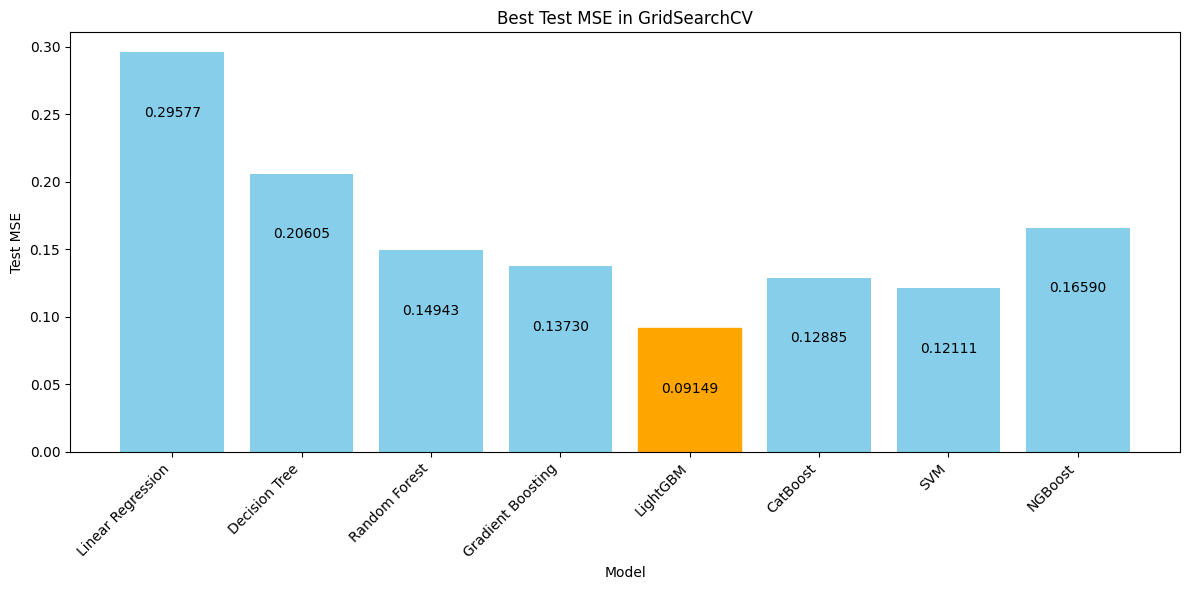

In [18]:
def plot_best_scores(best_scores_ran):
    # Extract model names and their corresponding best test MSE scores
    model_names = list(best_scores_ran.keys())
    test_mse_scores = [best_scores_ran[model]['test_mse'] for model in model_names]

    # Find the index of the model with the best (lowest) test MSE
    best_model_index = np.argmin(test_mse_scores)

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, test_mse_scores, color='skyblue')

    # Highlight the best model
    bars[best_model_index].set_color('orange')

    # Annotate the bars with the test MSE scores
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{test_mse_scores[i]:.5f}', ha='center', va='bottom', color='black')

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Test MSE')
    plt.title('Best Test MSE in GridSearchCV')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming best_scores is the output from the hyperparameter_tuning function
plot_best_scores(best_scores_ran= best_scores_grid)

# **Bayesian Optimisation**

In [36]:
def hyperparameter_tuning_bayes_opt(X_train, y_train, X_test, y_test):
    def optimize_model(model, param_bounds, X_train, y_train):
        def objective(**params):
            # Convert parameters to the correct types
            for key in params:
                if key in ['fit_intercept', 'copy_X', 'positive']:
                    params[key] = bool(round(params[key]))
                elif key in ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'iterations', 'num_leaves', 'degree', 'min_child_samples','depth']:
                    params[key] = int(round(params[key]))

            model.set_params(**params)
            # Use cross-validation to evaluate the model
            scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error, greater_is_better=False))
            return np.mean(scores)

        optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42, verbose=2)
        optimizer.maximize(init_points=5, n_iter=20)
        return optimizer.max

    models = {
        'Linear Regression': (LinearRegression(), {
            'fit_intercept': (0, 1),
            'copy_X': (0, 1),
            'positive': (0, 1)
        }),
        'Decision Tree': (DecisionTreeRegressor(), {
            'max_depth': (1, 20),
            'min_samples_split': (2, 11),
            'min_samples_leaf': (1, 5)
        }),
        'Random Forest': (RandomForestRegressor(), {
            'n_estimators': (100, 300),
            'max_depth': (1, 20),
            'min_samples_split': (2, 11),
            'min_samples_leaf': (1, 5)
        }),
        'Gradient Boosting': (GradientBoostingRegressor(), {
            'n_estimators': (100, 500),
            'learning_rate': (0.01, 0.2),
            'max_depth': (1, 20),
            'min_samples_split': (2, 11),
            'min_samples_leaf': (1, 5)
        }),
        'XGBoost': (XGBRegressor(), {
            'learning_rate': (0.01, 0.1),
            'max_depth': (3, 7),
            'n_estimators': (100, 500),
            'min_child_weight': (1, 5),
            'gamma': (0, 1),
            'subsample': (0.5, 0.9),
            'colsample_bytree': (0.5, 0.9)
        }),
        'LightGBM': (LGBMRegressor(verbosity=-1), {
            'learning_rate': (0.01, 0.1),
            'max_depth': (3, 7),
            'n_estimators': (100, 500),
            'num_leaves': (15, 63),
            'min_child_samples': (1, 10),
            'subsample': (0.5, 0.9),
            'colsample_bytree': (0.5, 0.9)
        }),
        'CatBoost': (CatBoostRegressor(verbose=0), {
            'learning_rate': (0.01, 0.1),
            'iterations': (100, 500),
            'depth': (3, 7),
            'l2_leaf_reg': (1, 5)
        }),
        'SVM': (SVR(), {
            'C': (0.1, 10),
            'gamma': (0.01, 1),
            'degree': (2, 4),
            'epsilon': (0.01, 1)
        }),
        'NGBoost': (NGBRegressor(), {
            'n_estimators': (100, 300),
            'learning_rate': (0.01, 0.1),
            'minibatch_frac': (0.5, 1.0)
        })
    }

    best_scores = {}
    for model_name, (model, param_bounds) in models.items():
        print(f"Running Bayesian Optimization for {model_name}...")
        try:
            best_result = optimize_model(model, param_bounds, X_train, y_train)
            best_params = best_result['params']
            # Convert parameters to the correct types for final model fitting
            for key in best_params:
                if key in ['fit_intercept', 'copy_X', 'positive']:
                    best_params[key] = bool(round(best_params[key]))
                elif key in ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'iterations', 'num_leaves', 'degree', 'min_child_samples','depth']:
                    best_params[key] = int(round(best_params[key]))

            model.set_params(**best_params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            best_scores[model_name] = {
                'best_score': -best_result['target'],
                'best_params': best_params,
                'test_mse': mse
            }
            print(f"Best MSE for {model_name}: {mse} with params: {best_params}")
        except Exception as e:
            print(f"Failed to run Bayesian Optimization for {model_name}. Error: {e}")

    # Find the model with the best test score
    if best_scores:
        best_model_name = min(best_scores, key=lambda k: best_scores[k]['test_mse'])
        best_model_info = best_scores[best_model_name]
        print(f"\nBest model on test data: {best_model_name}")
        print(f"Test MSE: {best_model_info['test_mse']}")
        print(f"Best Parameters: {best_model_info['best_params']}")
    else:
        print("No valid model configurations found.")

    return best_scores

best_scores_bayes_opt = hyperparameter_tuning_bayes_opt(X_train, y_train, X_test, y_test)

Running Bayesian Optimization for Linear Regression...
|   iter    |  target   |  copy_X   | fit_in... | positive  |
-------------------------------------------------------------
| 1         | -0.5041   | 0.3745    | 0.9507    | 0.732     |
| 2         | -1.843    | 0.5987    | 0.156     | 0.156     |
| 3         | -0.5041   | 0.05808   | 0.8662    | 0.6011    |
| 4         | -1.781    | 0.7081    | 0.02058   | 0.9699    |
| 5         | -1.843    | 0.8324    | 0.2123    | 0.1818    |
| 6         | -0.5041   | 0.005633  | 0.9857    | 0.9805    |
| 7         | -0.5123   | 0.01756   | 0.995     | 0.07354   |
| 8         | -0.5041   | 0.9697    | 0.9502    | 0.9731    |
| 9         | -0.5123   | 0.9958    | 0.9999    | 0.2895    |
| 10        | -0.5041   | 0.0076    | 0.9908    | 0.5074    |
| 11        | -0.5123   | 0.5577    | 0.9781    | 0.004288  |
| 12        | -0.5041   | 0.8991    | 0.9998    | 0.6393    |
| 13        | -0.5041   | 0.654     | 0.9995    | 0.9983    |
| 14        | -

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags_

| 2         | -0.3382   | 0.8465    | 0.0641    | 5.832     | 1.185     | 488.0     | 54.96     | 0.5849    |
| 3         | -0.3823   | 0.5727    | 0.02651   | 4.217     | 5.723     | 272.8     | 28.98     | 0.7447    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 4         | -0.376    | 0.5558    | 0.03629   | 4.465     | 5.105     | 414.1     | 24.58     | 0.7057    |
| 5         | -0.4456   | 0.737     | 0.01418   | 5.43      | 2.535     | 126.0     | 60.55     | 0.8863    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 6         | -0.4445   | 0.7827    | 0.09759   | 6.573     | 4.082     | 499.3     | 15.17     | 0.5111    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 7         | -0.3538   | 0.7148    | 0.09503   | 5.38      | 1.175     | 485.5     | 55.02     | 0.8534    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 8         | -0.3677   | 0.5371    | 0.06307   | 4.742     | 2.199     | 495.6     | 58.85     | 0.8733    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 9         | -0.3713   | 0.6231    | 0.07097   | 5.859     | 1.932     | 493.4     | 48.89     | 0.5584    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 10        | -0.3827   | 0.6818    | 0.05754   | 6.212     | 8.965     | 487.5     | 56.25     | 0.7288    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 11        | -0.3953   | 0.5701    | 0.0629    | 5.924     | 3.162     | 488.4     | 62.89     | 0.8227    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 12        | -0.3308   | 0.5932    | 0.03217   | 3.827     | 1.242     | 485.1     | 47.02     | 0.6833    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 13        | -0.3972   | 0.592     | 0.09344   | 6.481     | 2.961     | 480.5     | 41.92     | 0.5048    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 14        | -0.4339   | 0.7712    | 0.05724   | 5.285     | 3.583     | 486.8     | 50.14     | 0.6338    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 15        | -0.3737   | 0.7579    | 0.06515   | 6.025     | 2.057     | 488.2     | 56.44     | 0.7199    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 16        | -0.4331   | 0.6726    | 0.09359   | 3.224     | 2.183     | 485.5     | 45.75     | 0.761     |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 17        | -0.339    | 0.8111    | 0.07429   | 5.394     | 1.234     | 276.8     | 42.33     | 0.7703    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 18        | -0.3914   | 0.6349    | 0.09693   | 3.378     | 5.244     | 489.1     | 42.97     | 0.813     |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 19        | -0.4127   | 0.6977    | 0.08266   | 5.201     | 9.574     | 288.5     | 60.15     | 0.6259    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 20        | -0.4136   | 0.7986    | 0.04046   | 4.813     | 6.904     | 350.3     | 24.85     | 0.799     |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 21        | -0.4199   | 0.8754    | 0.08116   | 4.017     | 7.256     | 188.3     | 46.13     | 0.7947    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 22        | -0.3829   | 0.7692    | 0.05471   | 5.214     | 3.425     | 268.3     | 26.76     | 0.8965    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 23        | -0.4308   | 0.7129    | 0.07715   | 5.058     | 5.067     | 326.0     | 34.51     | 0.5044    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 24        | -0.4393   | 0.8352    | 0.06334   | 4.496     | 3.506     | 494.4     | 35.05     | 0.8016    |


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

| 25        | -0.3933   | 0.6316    | 0.07511   | 4.372     | 6.484     | 396.9     | 16.1      | 0.5789    |
Best MSE for LightGBM: 0.10251796161869138 with params: {'colsample_bytree': 0.5932399313787978, 'learning_rate': 0.03217027255925721, 'max_depth': 4, 'min_child_samples': 1, 'n_estimators': 485, 'num_leaves': 47, 'subsample': 0.6833135141648716}
Running Bayesian Optimization for CatBoost...
|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


| 1         | -0.3137   | 4.498     | 480.3     | 3.928     | 0.06388   |
| 2         | -0.3002   | 3.624     | 162.4     | 1.232     | 0.08796   |
| 3         | -0.312    | 5.404     | 383.2     | 1.082     | 0.09729   |
| 4         | -0.3527   | 6.33      | 184.9     | 1.727     | 0.02651   |
| 5         | -0.3142   | 4.217     | 309.9     | 2.728     | 0.03621   |
| 6         | -0.3301   | 4.115     | 163.5     | 1.783     | 0.09757   |
| 7         | -0.3322   | 3.197     | 107.4     | 3.402     | 0.07514   |
| 8         | -0.3627   | 3.018     | 116.1     | 2.866     | 0.04169   |
| 9         | -0.3117   | 6.883     | 383.8     | 4.976     | 0.04365   |
| 10        | -0.4337   | 4.886     | 164.2     | 4.208     | 0.01869   |
| 11        | -0.3169   | 4.831     | 160.8     | 1.455     | 0.04445   |
| 12        | -0.3834   | 4.939     | 383.2     | 3.338     | 0.01051   |
| 13        | -0.4245   | 3.522     | 161.4     | 1.272     | 0.01281   |
| 14        | -0.333    | 3.025     | 

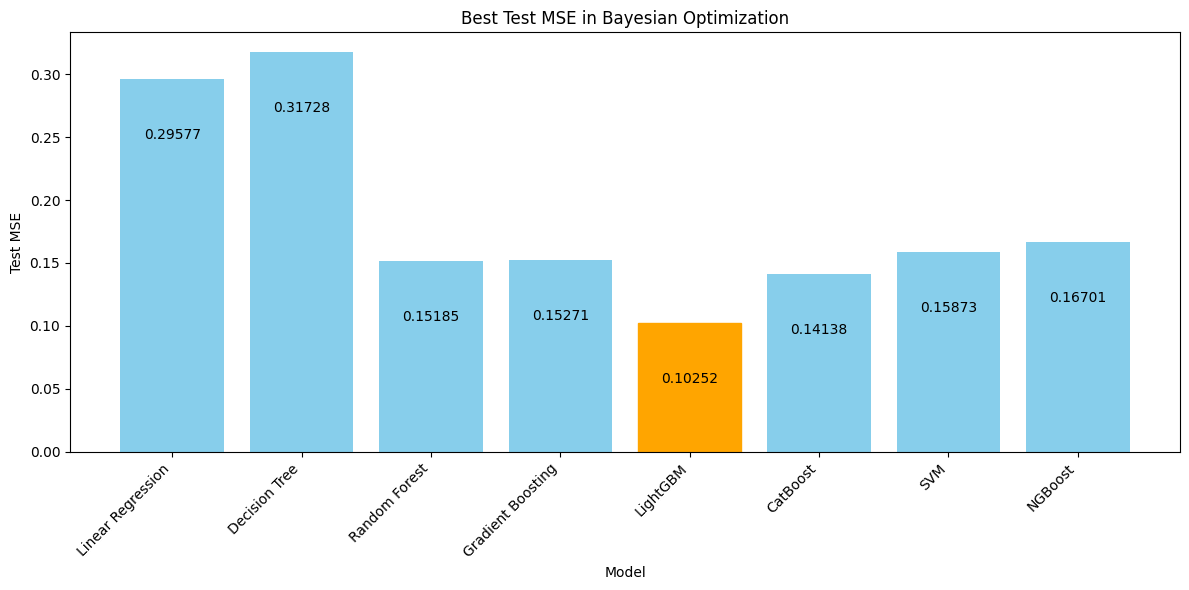

In [20]:
def plot_best_scores(best_scores):
    # Extract model names and their corresponding best test MSE scores
    model_names = list(best_scores.keys())
    test_mse_scores = [best_scores[model]['test_mse'] for model in model_names]

    # Find the index of the model with the best (lowest) test MSE
    best_model_index = np.argmin(test_mse_scores)

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, test_mse_scores, color='skyblue')

    # Highlight the best model
    bars[best_model_index].set_color('orange')

    # Annotate the bars with the test MSE scores
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{test_mse_scores[i]:.5f}', ha='center', va='bottom', color='black')

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Test MSE')
    plt.title('Best Test MSE in Bayesian Optimization') # Changed title
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_best_scores(best_scores_bayes_opt)

# **Applying the best model:**

In [56]:
model_classes = {

        'Linear Regression': LinearRegression,
        'Decision Tree': DecisionTreeRegressor,
        'Random Forest': RandomForestRegressor,
        'Gradient Boosting': GradientBoostingRegressor,
        'XGBoost': XGBRegressor,
        'LightGBM': LGBMRegressor,
        'GPBoost': GPBoostRegressor,
        'CatBoost': CatBoostRegressor,
        'SVM': SVR,
        'NGBoost': NGBRegressor
  }

def find_best_model_and_predict(best_scores_ran, best_scores_grid, best_scores_bayes_opt, X_train, y_train, X_test):
    # Combine all results into a single dictionary
    all_results = {
        'Random Search': best_scores_ran,
        'Grid Search': best_scores_grid,
        'Bayesian Optimization': best_scores_bayes_opt
    }

    # Initialize a dictionary to store the best model for each algorithm
    best_models = {}

    # Iterate over each model type
    for model_name in best_scores_ran.keys():
        # Initialize variables to track the best MSE and corresponding method
        best_mse = float('inf')
        best_method = None
        best_params = None

        # Check each tuning method for the current model
        for method, results in all_results.items():
            model_results = results[model_name]
            if model_results['test_mse'] < best_mse:
                best_mse = model_results['test_mse']
                best_method = method
                best_params = model_results['best_params']

        # Store the best model information
        best_models[model_name] = {
            'best_mse': best_mse,
            'best_method': best_method,
            'best_params': best_params
        }

    # Find the overall best model across all model types
    overall_best_model = None
    overall_best_mse = float('inf')

    for model_name, model_info in best_models.items():
        if model_info['best_mse'] < overall_best_mse:
            overall_best_mse = model_info['best_mse']
            overall_best_model = {
                'model_name': model_name,
                'best_mse': model_info['best_mse'],
                'best_method': model_info['best_method'],
                'best_params': model_info['best_params']
            }

    # Print the overall best model
    print("Overall Best Model:")
    print(f"Model Name: {overall_best_model['model_name']}")
    print(f"Best MSE: {overall_best_model['best_mse']}")
    print(f"Best Method: {overall_best_model['best_method']}")
    print(f"Best Parameters: {overall_best_model['best_params']}")

    # Instantiate the best model using the dictionary
    model_name = overall_best_model['model_name']
    best_params = overall_best_model['best_params']
    model_class = model_classes.get(model_name)

    if model_class is None:
        raise ValueError(f"Model {model_name} is not supported.")

    # Special handling for CatBoost to suppress verbose output
    if model_name == 'CatBoost':
        model = model_class(**best_params, verbose=0)
    else:
        model = model_class(**best_params)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    return predictions

predictions = find_best_model_and_predict(best_scores_ran, best_scores_grid, best_scores_bayes_opt, X_train, y_train, X_test)

Overall Best Model:
Model Name: LightGBM
Best MSE: 0.09148999237592116
Best Method: Grid Search
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 500, 'num_leaves': 15, 'subsample': 0.5}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [57]:
print(predictions[:5])

[0.34165401 0.15922896 0.78737917 0.73479523 0.40387114]


In [59]:
file_path = '/content/drive/MyDrive/flood_scour_data/test_data_new.csv'

# Read the existing CSV file
df = pd.read_csv(file_path)

# Assuming `predictions` is the array of predicted values
# predictions = find_best_model_and_predict(best_scores_ran, best_scores_grid, best_scores_bayes_opt, X_train, y_train, X_test)

# Check if the number of predictions matches the number of rows in the DataFrame
if len(predictions) != len(df):
    raise ValueError("The number of predictions does not match the number of rows in the CSV file.")

# Add the predictions as a new column
df['Scour_predicted'] = np.round(predictions, 2)

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print("Predictions have been added to the CSV file.")

Predictions have been added to the CSV file.
